In [1]:
%reset -sf

import tensorflow as tf
print(tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_384 *2 # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-09-09 05:12:06.644916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
2 Physical GPUs, 1 Logical GPU


2024-09-09 05:12:12.489176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32768 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [2]:
import sys
import os
import glob
HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH+"/qe")

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

# INN packages
from flow import *
from utils import *

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib as mpl
import shap

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 76

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 8_192
EPOCHS = 1_024
LEARNING_RATE = 1e-6

In [5]:
## Observing variables

lead_lep = data.LeadLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
sublead_lep = data.SubLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
met = data.MET[["px", "py", "pt", "phi"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1378510, 18)
<class 'numpy.ndarray'>


In [6]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()[PRE_CUT]
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()[PRE_CUT]

# Kinematics of interesting variables (target for training)
int_kin = pd.concat([w_sublead[["px", "py", "pz", "E", "pt"]] / GEV, 100*w_sublead["eta"]], axis=1)
print("int_kin shape:", int_kin.shape)
int_kin = int_kin.to_numpy() # convert to numpy array
print(type(int_kin))

int_kin shape: (1378510, 6)
<class 'numpy.ndarray'>


In [7]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (551404, 18);
Validing data shape: (413553, 18);
Testing data shape: (413553, 18).
Y (Observed)
Training data shape: (551404, 6);
Validing data shape: (413553, 6);
Testing data shape: (413553, 6).


In [8]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        px = w[:, 0]
        py = w[:, 1]
        pz = w[:, 2]
        energy = w[:, 3]
        # Calculate the constraint
        constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
        # Create a mask for invalid four-vectors (constraint == 0)
        mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = w * tf.expand_dims(mask, axis=-1)
        return adjusted_w

# Register the custom activation and constraint
tf.keras.utils.get_custom_objects().update({
    'EPConstraint': EPConstraint,
})


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)
    for _ in range(5):
        x = tf.keras.layers.Dense(units=4096, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.3)(x)
        x = tf.keras.layers.Dense(units=1024, activation="selu")(x)
        x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=512, activation="selu")(x)
    x = tf.keras.layers.Dense(units=512, activation="selu")(x)
    x = tf.keras.layers.Dense(units=512, activation="selu")(x)
    x = tf.keras.layers.Dense(units=512, activation="selu")(x)

    outputs = tf.keras.layers.Dense(units=6, activation="linear", kernel_constraint=EPConstraint())(x)
    
    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.losses.mean_absolute_error,
    )

    return model

In [9]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 128)               2432      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 4096)              528384

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=32,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return lr
    else:
        return lr * tf.math.exp(-LEARNING_RATE)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[stop_early,lr_scheduler],
)

Epoch 1/1024


2024-09-09 05:12:43.194965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-09 05:12:43.224737: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad7925c790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-09 05:12:43.224798: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-09 05:12:43.232464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-09 05:12:44.518011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-09 05:12:44.672224: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

68/68 - 20s - loss: 86.6126 - val_loss: 85.3667 - lr: 1.0000e-06 - 20s/epoch - 295ms/step
Epoch 2/1024
68/68 - 6s - loss: 85.6083 - val_loss: 84.3145 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 3/1024
68/68 - 6s - loss: 84.5258 - val_loss: 83.3247 - lr: 1.0000e-06 - 6s/epoch - 81ms/step
Epoch 4/1024
68/68 - 6s - loss: 83.4795 - val_loss: 82.2240 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 5/1024
68/68 - 6s - loss: 82.2769 - val_loss: 80.7847 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 6/1024
68/68 - 6s - loss: 80.5964 - val_loss: 78.5656 - lr: 1.0000e-06 - 6s/epoch - 81ms/step
Epoch 7/1024
68/68 - 6s - loss: 77.9309 - val_loss: 75.3767 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 8/1024
68/68 - 6s - loss: 74.7403 - val_loss: 72.5198 - lr: 1.0000e-06 - 6s/epoch - 83ms/step
Epoch 9/1024
68/68 - 6s - loss: 71.7288 - val_loss: 69.1647 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 10/1024
68/68 - 6s - loss: 67.9994 - val_loss: 64.7659 - lr: 1.0000e-06 - 6s/epoch - 82ms/step
Epoch 11/

In [11]:
# Make a directory
dir_name = HOME_PATH + "/4th_trial_report/w_sublead_result_report/"
name = "dnn_w_sublead"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save model
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/4th_trial_report/w_sublead_result_report/ cleaned.
Directory /root/work/QE-mls/4th_trial_report/w_sublead_result_report/ exists.
12924/12924 [==============================] - 30s 2ms/step


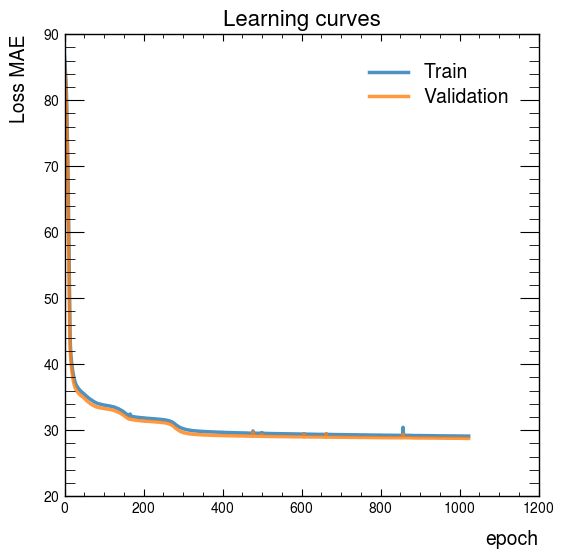

In [12]:
plot.plot_loss_history(history, logx=False, logy=False, loss_name="MAE")

In [13]:
# name the file
name = "dnn_w_sublead"

# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz", pred_y=sig_pred.reshape(sig_truth.shape), test_y=sig_truth
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.017, std: 26.723, min: -691.161, max: 473.069


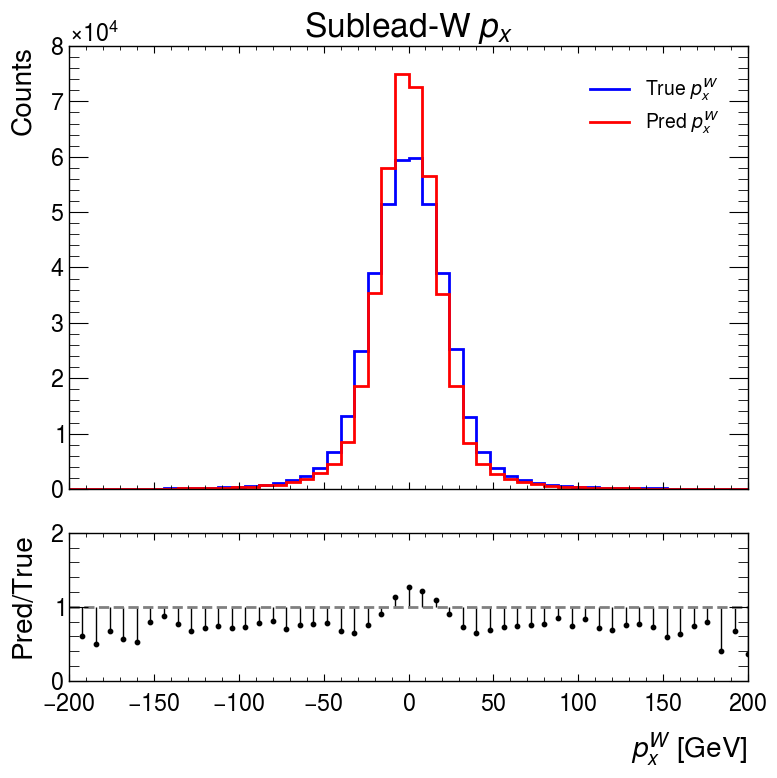

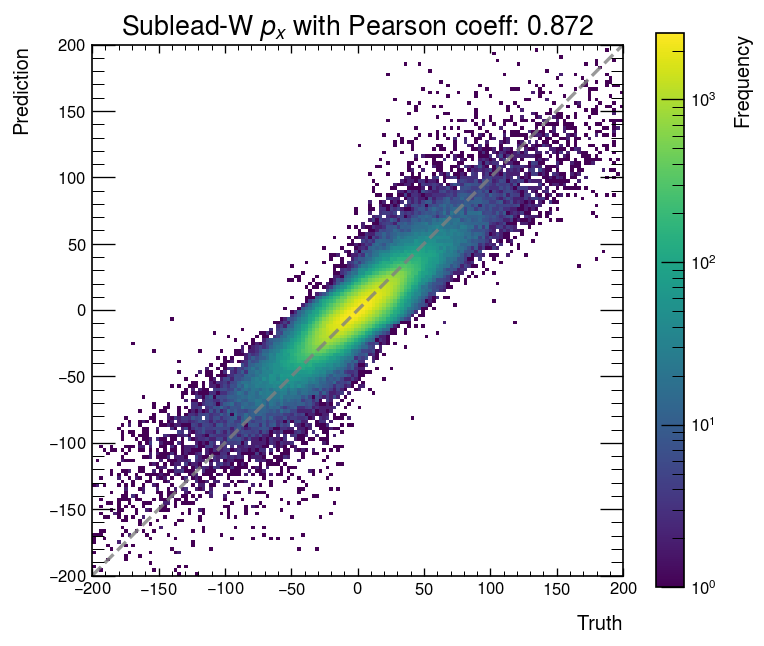

In [14]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="Sublead-W $p_{x}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Sublead-W $p_{x}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=set_range,
)

Truth mean: -0.060, std: 26.755, min: -542.501, max: 575.958


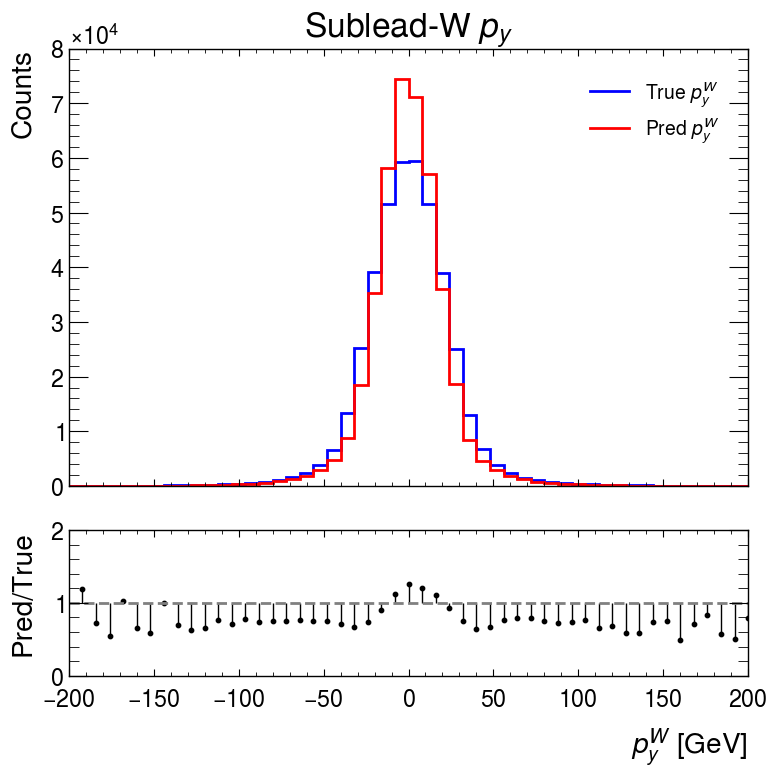

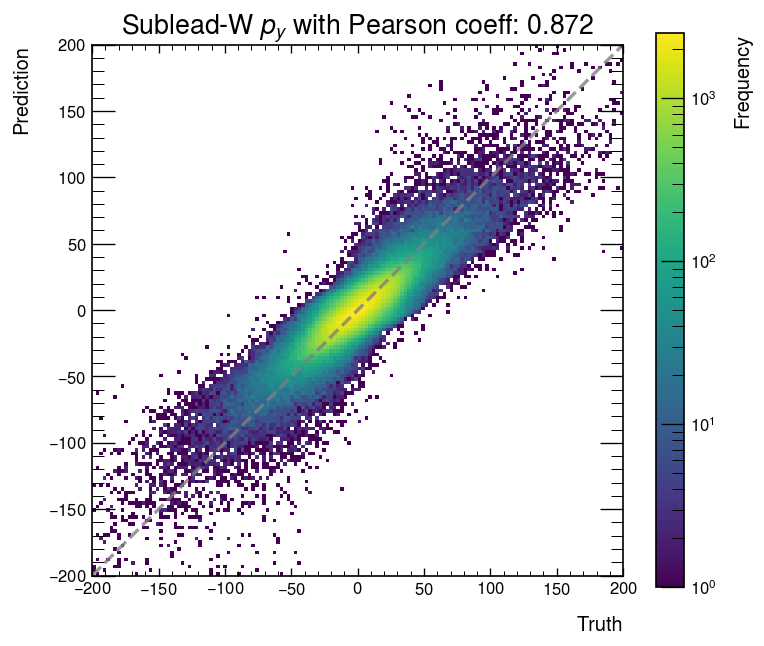

In [15]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="Sublead-W $p_{y}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Sublead-W $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.431, std: 213.486, min: -3232.335, max: 3210.099


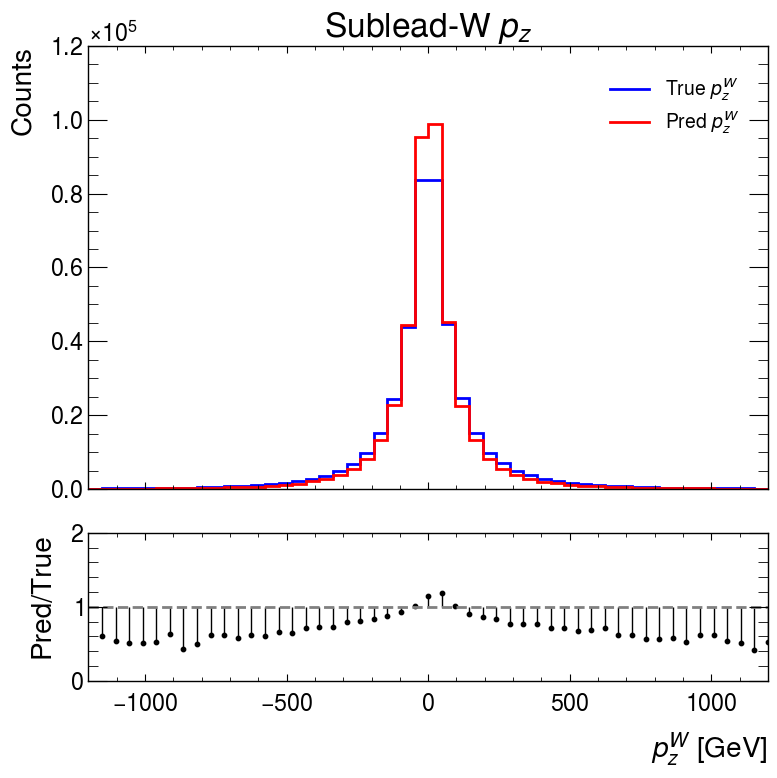

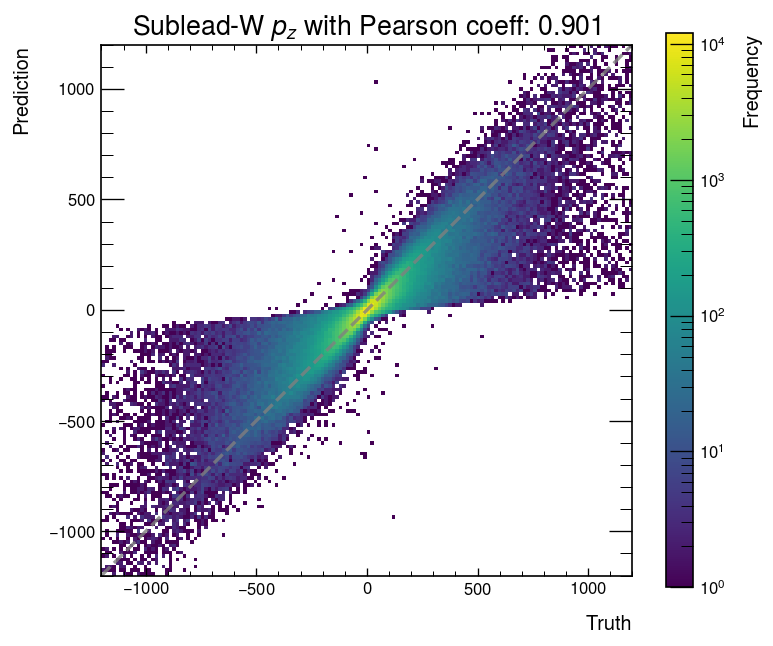

In [16]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-1200, 1200]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="Sublead-W $p_{z}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Sublead-W $p_{z}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=set_range,
)

Truth mean: 146.029, std: 166.382, min: 17.567, max: 3234.037


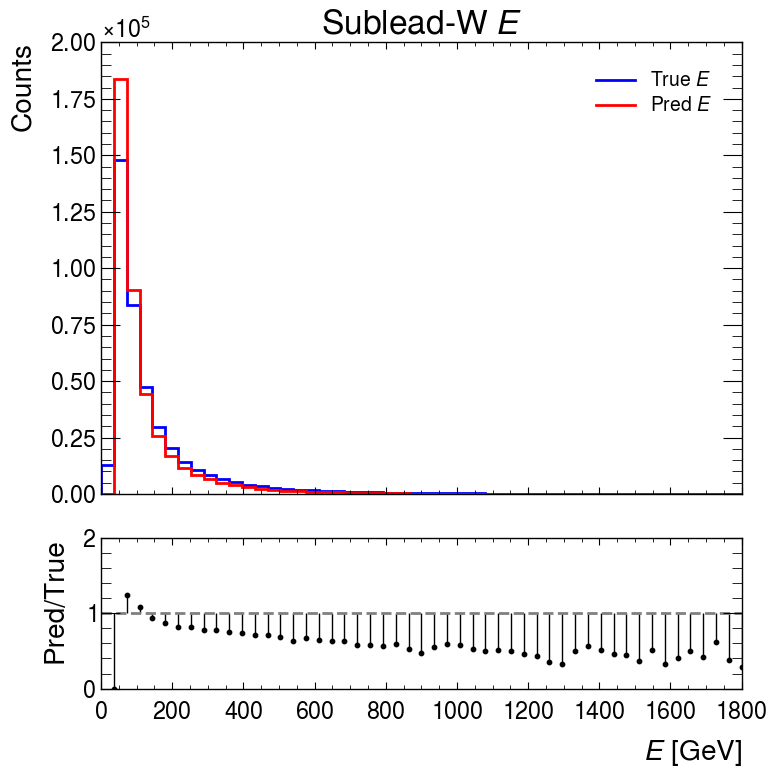

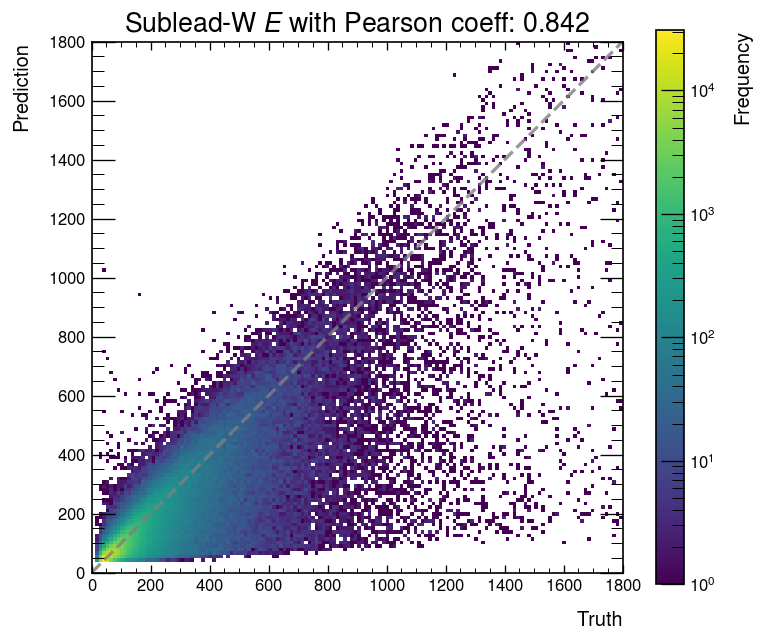

In [17]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:,3], sig_pred_inv[:,3]],
    label=r"$E$",
    title="Sublead-W $E$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:,3],
    sig_pred_inv[:,3],
    r"Sublead-W $E$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=set_range,
)

Truth mean: 29.919, std: 23.125, min: 0.038, max: 692.852


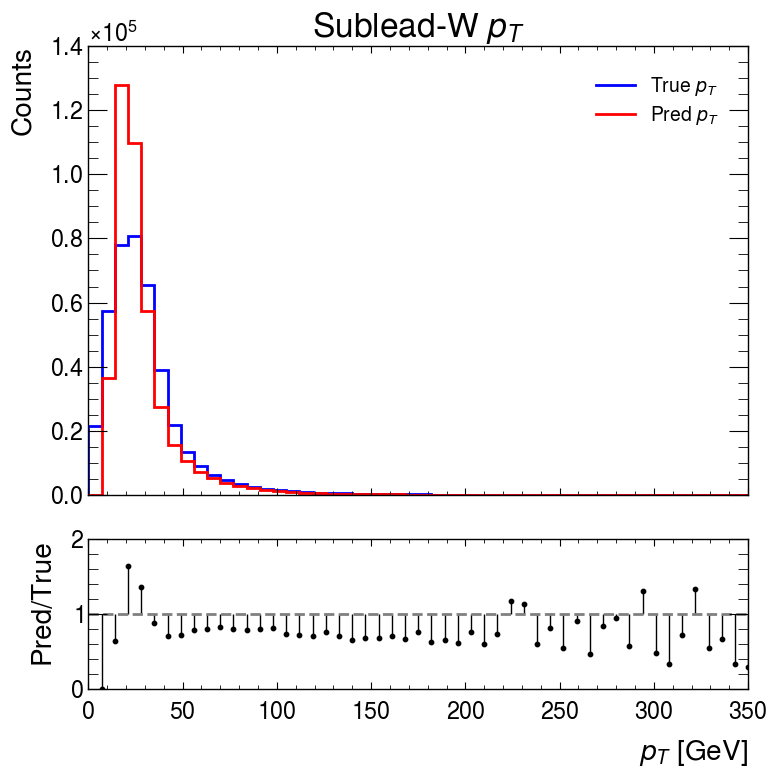

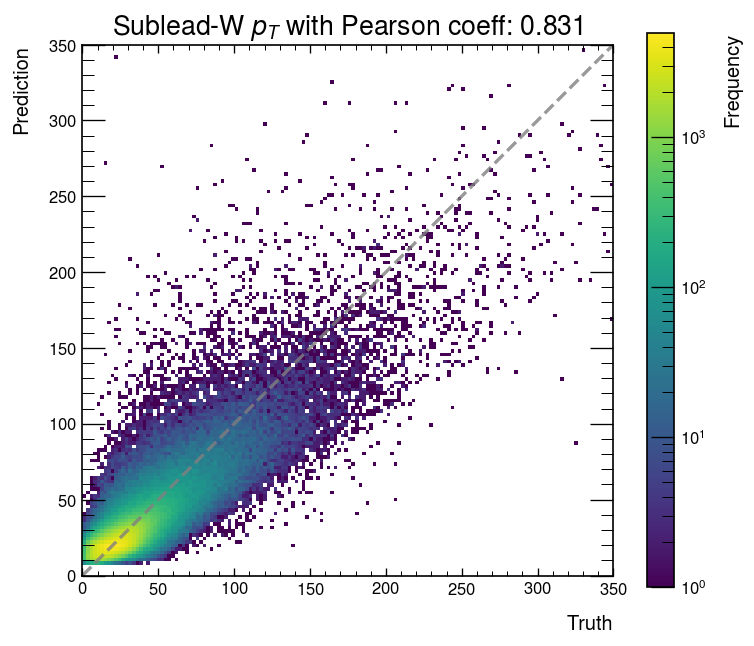

In [18]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [0, 350]

plot.hist(
    data=[sig_truth_inv[:,4], sig_pred_inv[:,4]],
    label=r"$p_{T}$",
    title="Sublead-W $p_{T}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:,4],
    sig_pred_inv[:,4],
    r"Sublead-W $p_{T}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,4], sig_pred_inv[:,4])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.008, std: 2.155, min: -8.470, max: 8.893


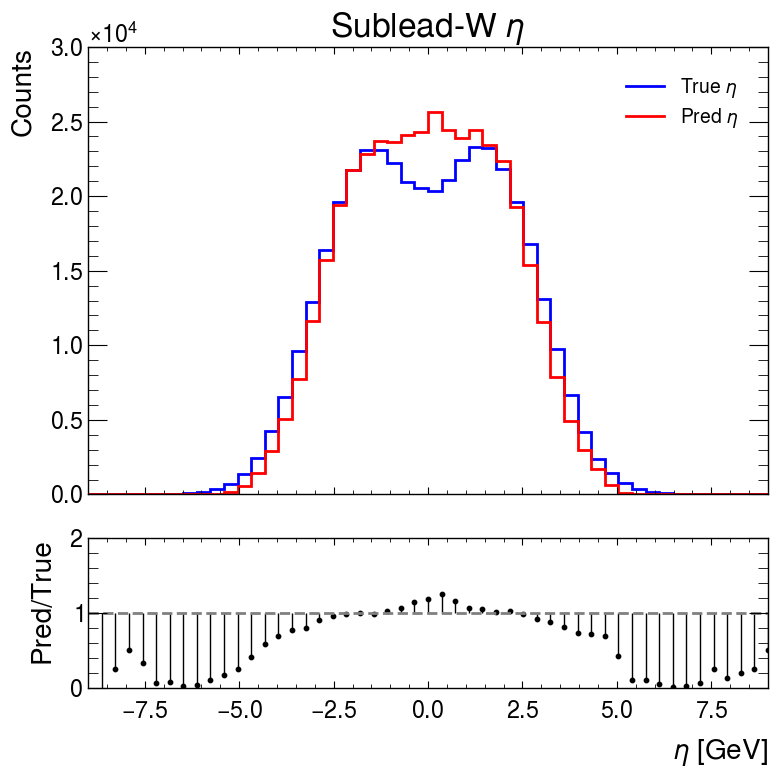

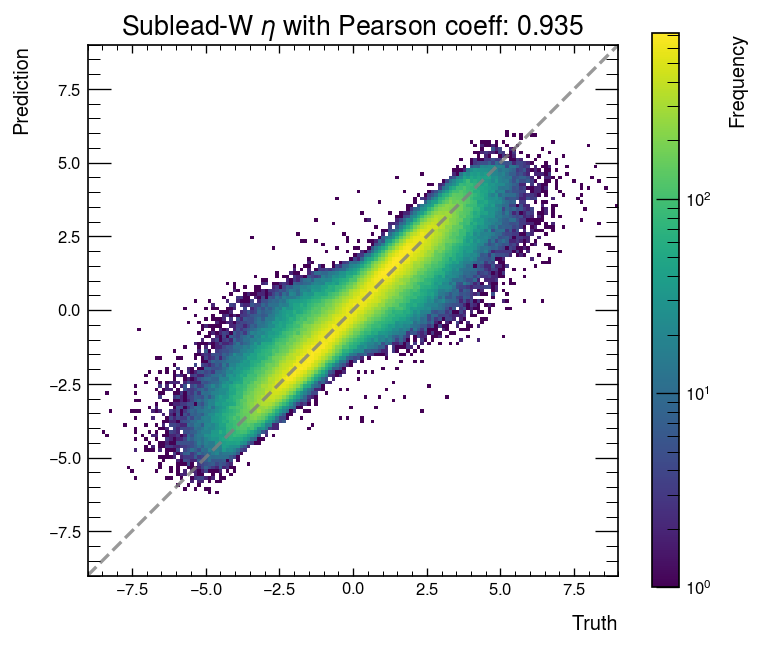

In [19]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]/100):.3f}, std: {np.std(sig_truth_inv[:,5]/100):.3f}, min: {np.min(sig_truth_inv[:,5]/100):.3f}, max: {np.max(sig_truth_inv[:,5]/100):.3f}"
)

set_range = [-9, 9]

plot.hist(
    data=[sig_truth_inv[:,5]/100, sig_pred_inv[:,5]/100],
    label=r"$\eta$",
    title="Sublead-W $\eta$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5]/100, sig_pred_inv[:,5]/100)):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:,5]/100,
    sig_pred_inv[:,5]/100,
    r"Sublead-W $\eta$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,5]/100, sig_pred_inv[:,5]/100)[0]:.3f}",
    range=set_range,
)

Truth mean: 0.431, std: 213.486, min: -3232.334, max: 3210.101


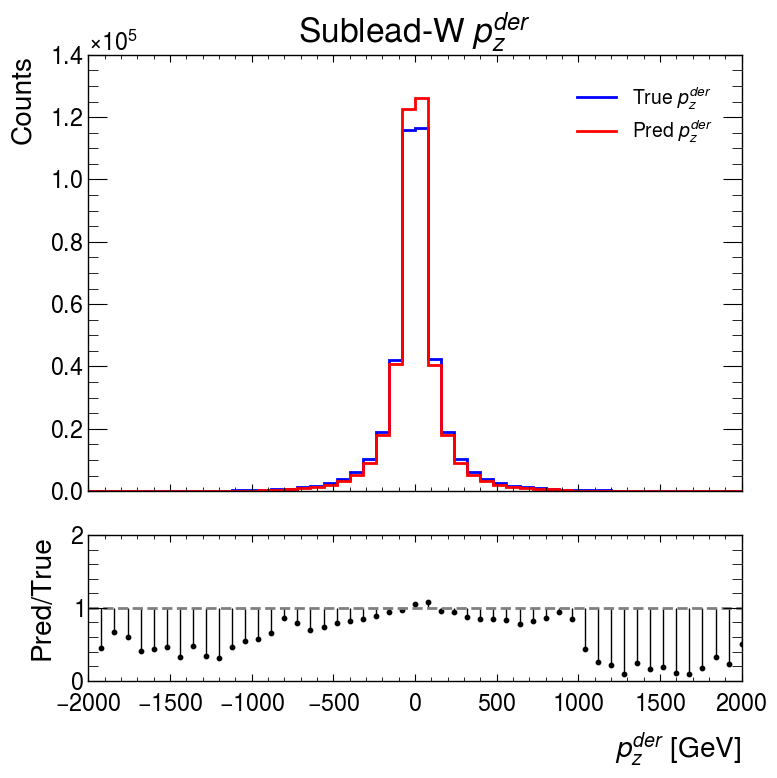

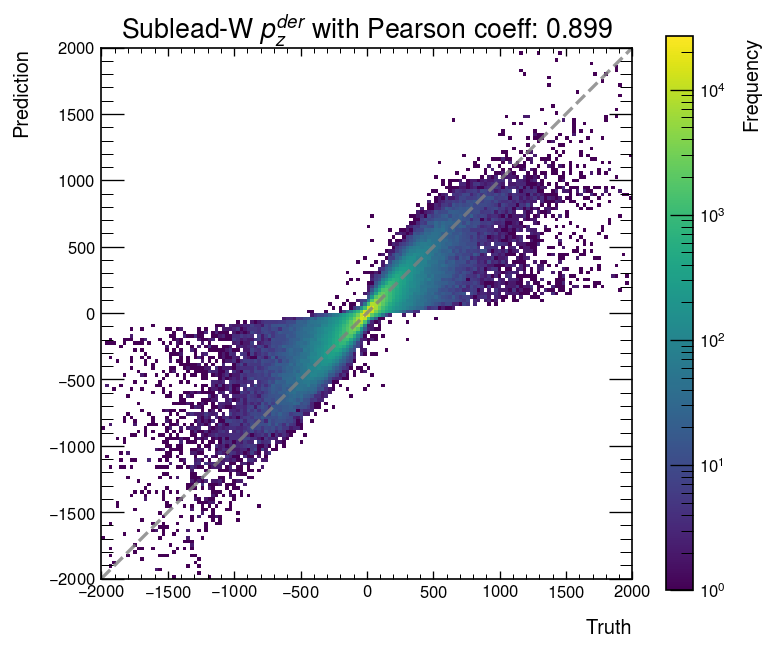

In [20]:
derived_pz_truth = sig_truth_inv[:,4] * np.sinh(sig_truth_inv[:,5]/100)
derived_pz = sig_pred_inv[:,4] * np.sinh(sig_pred_inv[:,5]/100)
print(
    f"Truth mean: {np.mean(derived_pz_truth):.3f}, std: {np.std(derived_pz_truth):.3f}, min: {np.min(derived_pz_truth):.3f}, max: {np.max(derived_pz_truth):.3f}"
)

set_range = [-2000, 2000]

plot.hist(
    data=[derived_pz_truth, derived_pz],
    label=r"$p_{z}^{der}$",
    title="Sublead-W $p_{z}^{der}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(derived_pz_truth,derived_pz)):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    derived_pz_truth,
    derived_pz,
    r"Sublead-W $p_{z}^{der}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(derived_pz_truth, derived_pz)[0]:.3f}",
    range=set_range,
)

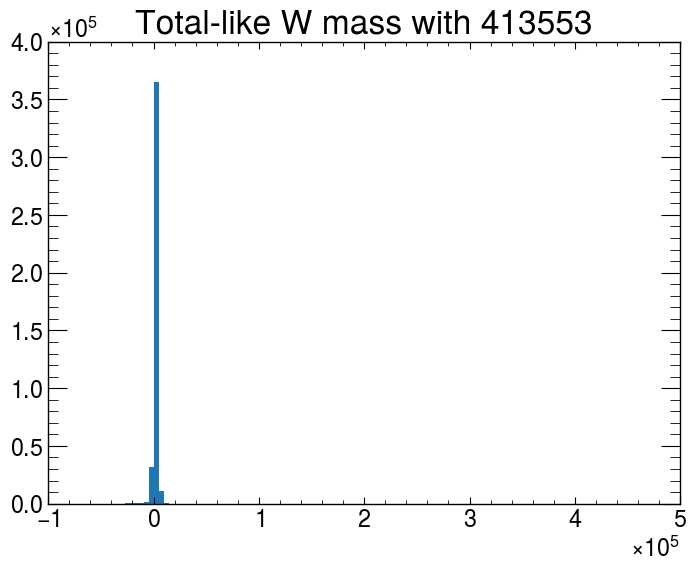

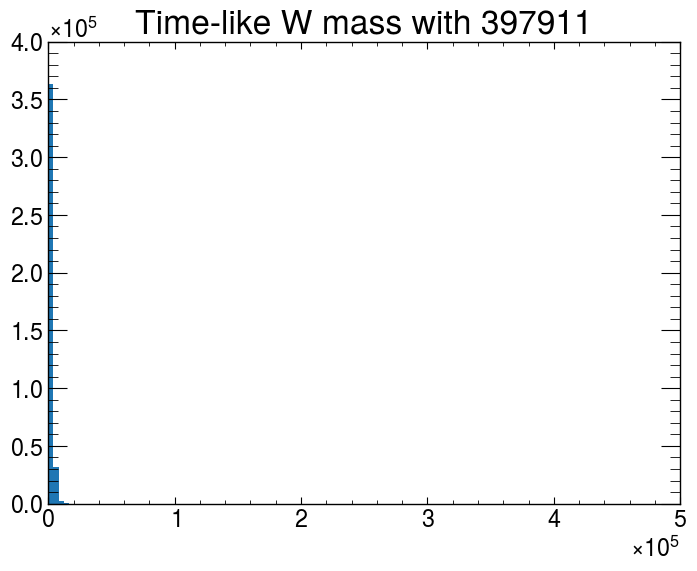

In [21]:
truth_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
truth_time_mask = truth_time_like >= 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

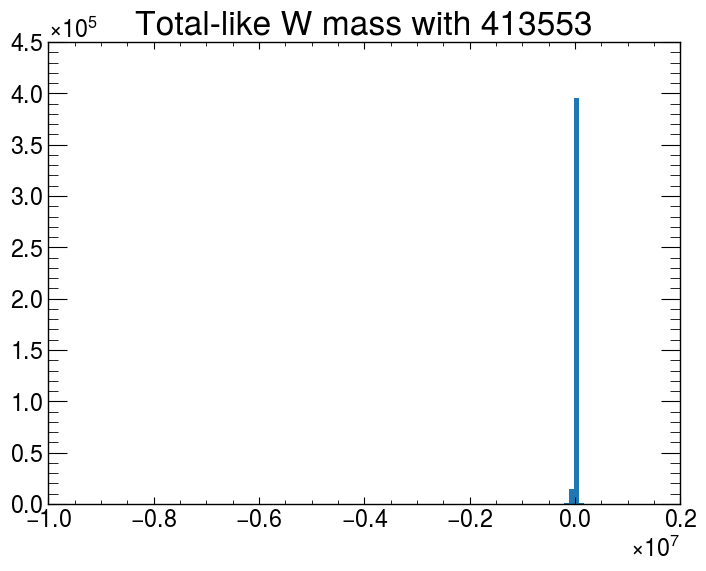

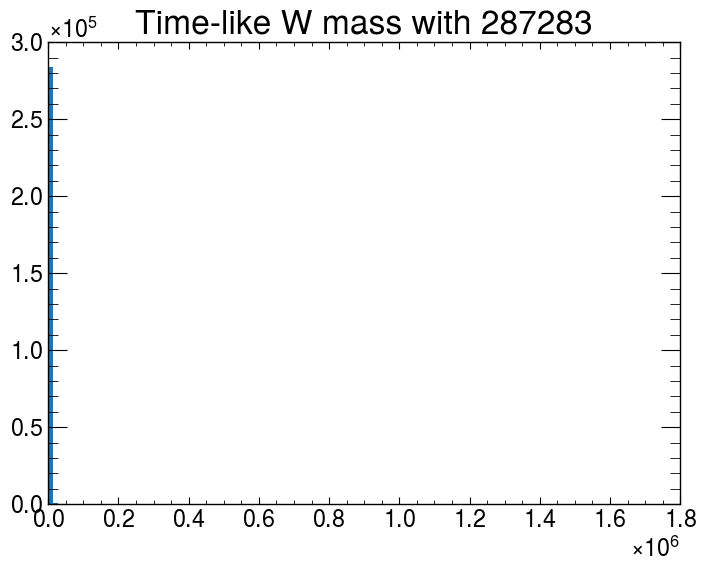

In [22]:
truth_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:2]), axis=1
) - np.square(derived_pz)
truth_time_mask = truth_time_like >= 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

/root/miniconda3/envs/tf/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


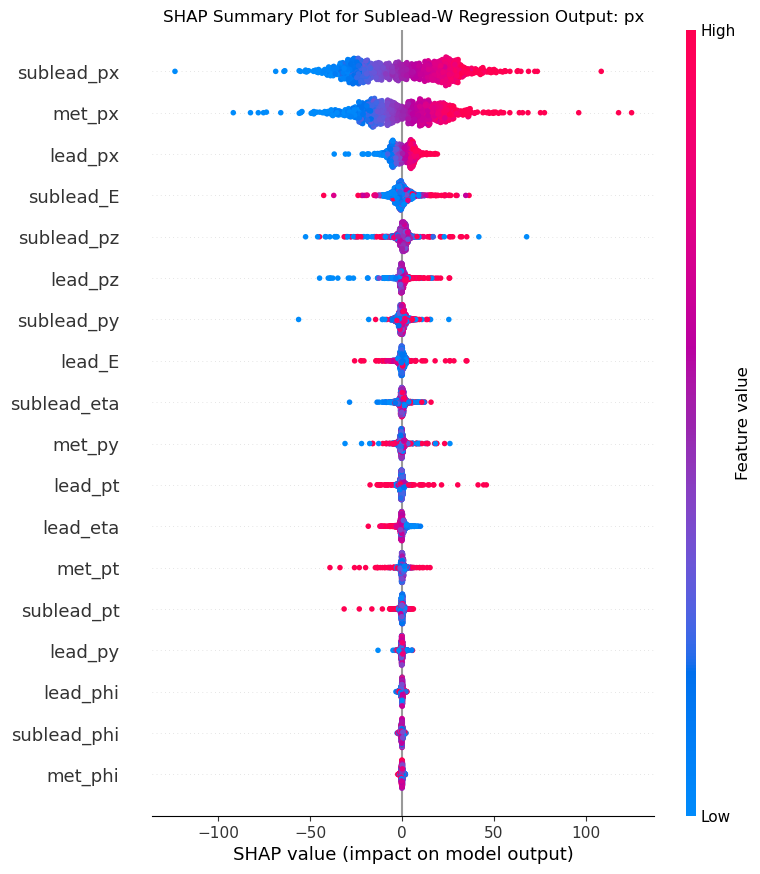

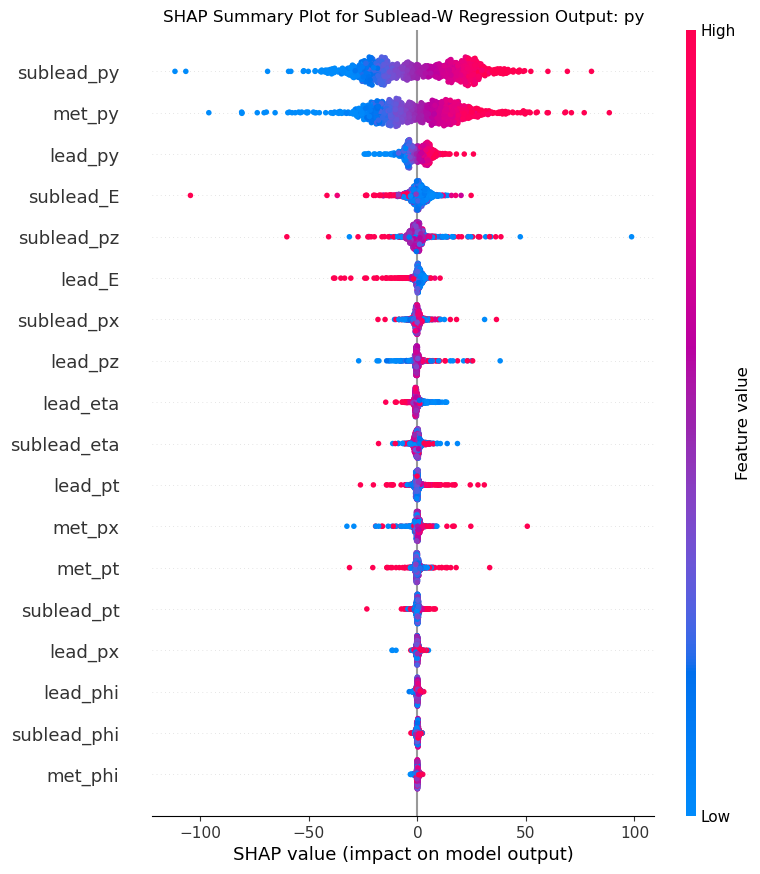

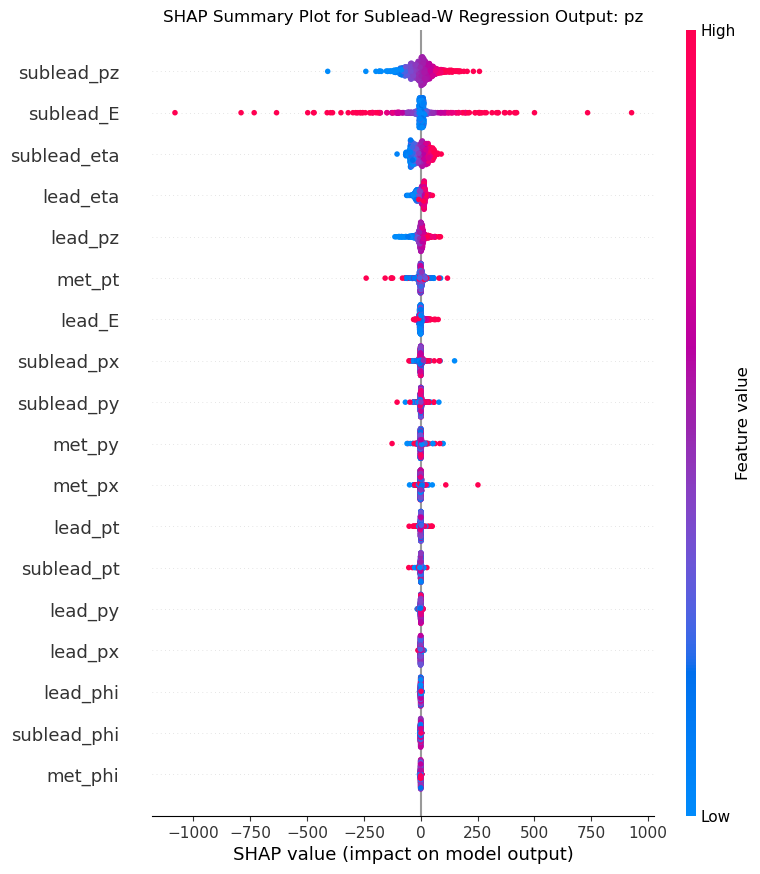

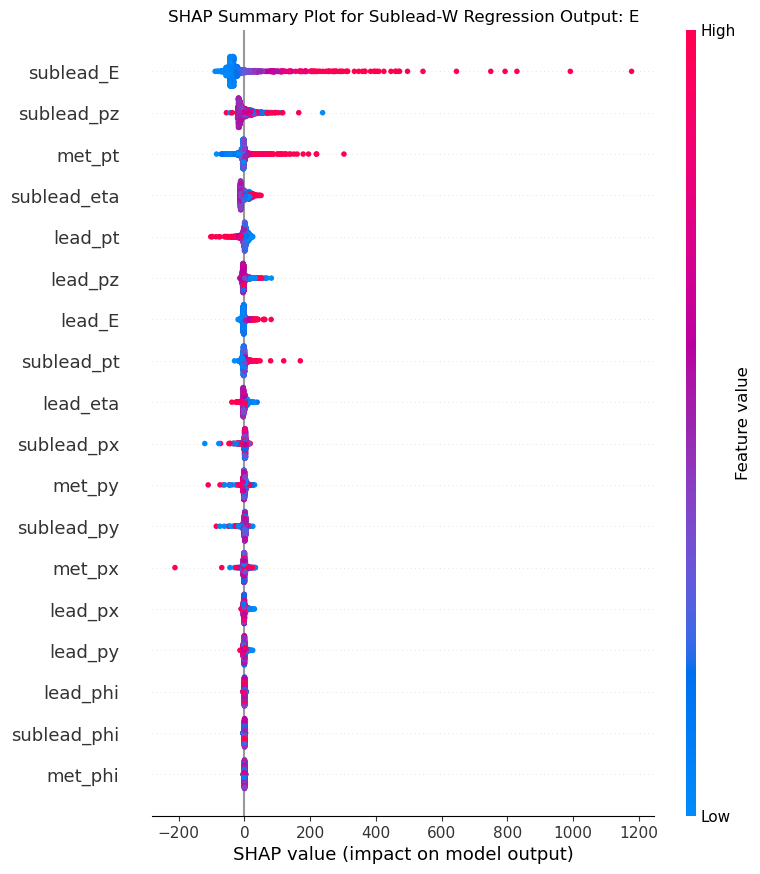

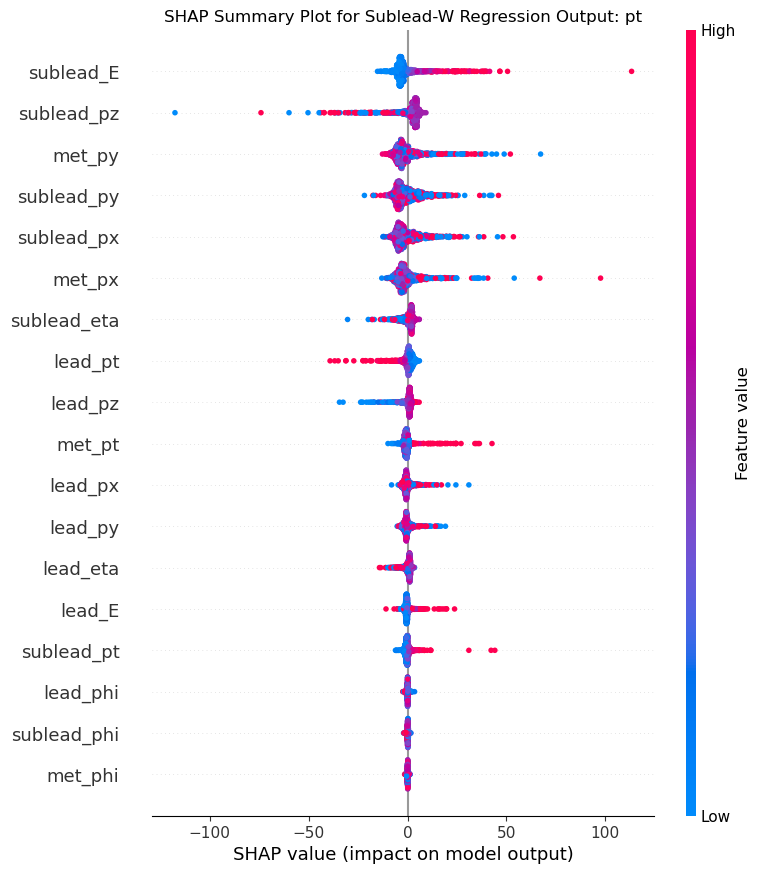

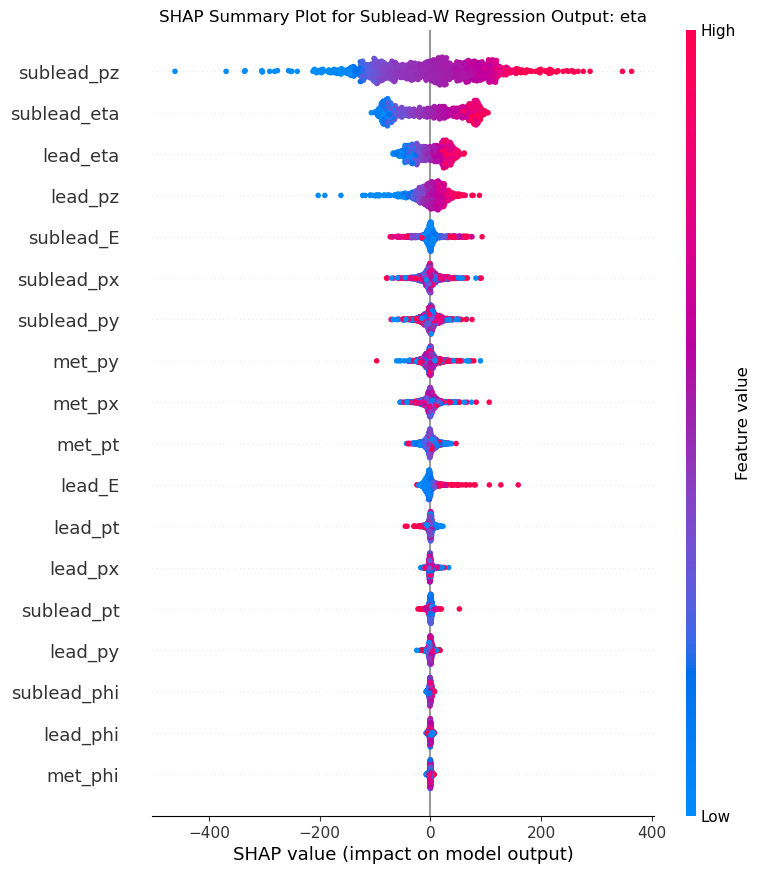

In [23]:
import shap
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

feature_names = [
    "lead_px",
    "lead_py",
    "lead_pz",
    "lead_E",
    "lead_pt",
    "lead_eta",
    "lead_phi",
    "sublead_px",
    "sublead_py",
    "sublead_pz",
    "sublead_E",
    "sublead_pt",
    "sublead_eta",
    "sublead_phi",
    "met_px",
    "met_py",
    "met_pt",
    "met_phi"
]
title_name = ["px", "py", "pz", "E", "pt", "eta"]
# lead
# Use DeepExplainer for SHAP values
explainer = shap.DeepExplainer(model, obs_kin[:1024])
shap_values = explainer.shap_values(obs_kin[:1024], check_additivity=False)
for i in range(shap_values.shape[-1]):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],
        obs_kin[:1024],
        feature_names=feature_names,
        plot_type="dot",
        show=False,
    )
    plt.title(f"SHAP Summary Plot for Sublead-W Regression Output: {title_name[i]}")
    plt.show()